### Housekeeping

In [2]:
#packages below

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

import statsmodels.api as sm
from statsmodels.iolib.summary2 import summary_col

from sklearn.model_selection import train_test_split 
from sklearn.linear_model import Lasso, LassoCV 
from sklearn.linear_model import Ridge, RidgeCV 
from sklearn.preprocessing import normalize
import scipy.cluster.hierarchy as shc
from sklearn.cluster import AgglomerativeClustering 
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix 
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline

## Data from FRED
#### FRED API Key
'/Users/joanne/Desktop/ECON1680/Project1/fred_apikey.txt'
'31f9bf2f6db8c5f4693e171619a73623'

In [3]:
#set up full fred
from full_fred.fred import Fred
apiKey = '/Users/joanne/Desktop/ECON1680/Project1/fred_apikey.txt'
fred = Fred(apiKey)
fred.get_api_key_file()


'/Users/joanne/Desktop/ECON1680/Project1/fred_apikey.txt'

In [4]:
#save FRED ticker names for real GDP, unemployment rate, and spread between 10 year and 2 year treasury
rGDP = 'GDPC1'
une = 'UNRATE'
yieldInv = 'T10Y2Y'

#CSCICP03USM665S consumer confidence normalized at 100


In [5]:
#get some data from FRED
dfGdp = fred.get_series_df(rGDP)
dfUne = fred.get_series_df(une)
dfyield = fred.get_series_df(yieldInv)

In [6]:
# make quarterly data from start date to end date
def clean(df,keep_cols,name,startDate,endDate):
    
    #keep only certain columns
    existing_cols = [col for col in keep_cols if col in df.columns]
    if existing_cols:
        df = df.loc[:, existing_cols]
    
    #convert index datetime
    df['date'] = pd.to_datetime(df['date'])
    df = df.set_index('date')
    
    #select date range
    df = df.loc[startDate:endDate]
    
    #backfill all empties & make sure that df['value'] is numeric
    df = df.replace('.',np.nan)
    df = df.fillna(method = 'backfill')
    df['value'] = pd.to_numeric(df['value'], downcast = 'float')
    
    #create year year variable
    df['Year'] = pd.PeriodIndex(df.index, freq='Y').to_timestamp()
    
    #group by quarter variable
    df = df.groupby(by = ['Year']).mean()
    
    #rename 'value' to something more descriptive
    df = df.rename(columns = {'value':name})
    
    return df

#run functions to reorganize dataframes
cNames = ['date','value']
cleanDfGdp = clean(dfGdp,cNames,'Growth','2005-01-01','2021-12-31')
cleanDfUne = clean(dfUne,cNames,'Unemployment','2006-01-01','2021-12-31')
cleanDfYield = clean(dfyield,cNames,'10y2yspread','2006-01-01','2021-12-31')

In [7]:
#conver GDP into yearly growth
cleanDfGdp = cleanDfGdp.pct_change()*100
cleanDfGdp = cleanDfGdp.dropna()
cleanDfGdp

Growth
Year                
2006-01-01  2.782810
2007-01-01  2.010512
2008-01-01  0.122190
2009-01-01 -2.599889
2010-01-01  2.708852
2011-01-01  1.549900
2012-01-01  2.280688
2013-01-01  1.841879
2014-01-01  2.287769
2015-01-01  2.706373
2016-01-01  1.667476
2017-01-01  2.241933
2018-01-01  2.945375
2019-01-01  2.294445
2020-01-01 -2.767956
2021-01-01  5.946624

In [8]:
#aggregate all fred data of interest
dfFred = cleanDfGdp.join(cleanDfUne)
dfFred = dfFred.join(cleanDfYield)

#yearly
dfFred = dfFred.set_index(dfFred.index.year)

#check
dfFred



Growth  Unemployment  10y2yspread
Year                                     
2006  2.782810      4.608333    -0.023654
2007  2.010512      4.616667     0.272567
2008  0.122190      5.800000     1.653702
2009 -2.599889      9.283333     2.304253
2010  2.708852      9.608334     2.510077
2011  1.549900      8.933333     2.328692
2012  2.280688      8.075000     1.525709
2013  1.841879      7.358333     2.045364
2014  2.287769      6.158333     2.077165
2015  2.706373      5.275000     1.450268
2016  1.667476      4.875000     1.005747
2017  2.241933      4.358334     0.930077
2018  2.945375      3.891667     0.382912
2019  2.294445      3.683333     0.172375
2020 -2.767956      8.091666     0.500802
2021  5.946624      5.366667     1.177165

In [9]:
#Dummy variables
dfFredDum = pd.DataFrame(index = dfFred.index)

#For all columns in dfFred
dfFredDum['Growth Dummy'] = (dfFred['Growth'] < 0).astype(int)
dfFredDum['Unemployment Dummy'] = (dfFred['Unemployment'] > 5).astype(int)
dfFredDum['10y2yspread Dummy'] = (dfFred['10y2yspread'] < 0).astype(int)



In [10]:
# Create the 'R' dummy variable, indicating recession
dfFredDum['R'] = ((dfFredDum['Growth Dummy'] != 0) | 
                  (dfFredDum['Unemployment Dummy'] != 0) | 
                  (dfFredDum['10y2yspread Dummy'] != 0)).astype(int)

dfFredDum

Growth Dummy  Unemployment Dummy  10y2yspread Dummy  R
Year                                                        
2006             0                   0                  1  1
2007             0                   0                  0  0
2008             0                   1                  0  1
2009             1                   1                  0  1
2010             0                   1                  0  1
2011             0                   1                  0  1
2012             0                   1                  0  1
2013             0                   1                  0  1
2014             0                   1                  0  1
2015             0                   1                  0  1
2016             0                   0                  0  0
2017             0                   0                  0  0
2018             0                   0                  0  0
2019             0                   0                  0  0
2020             1                   1                  0  1
2021             0                   1                  0  1

In [11]:
dfRecession = pd.DataFrame(index = dfFred.index)
dfRecession = dfRecession.join(dfFred['Growth'])
dfRecession = dfRecession.join(dfFredDum['Growth Dummy'])
dfRecession = dfRecession.join(dfFredDum['R'])                                
dfRecession

Growth  Growth Dummy  R
Year                           
2006  2.782810             0  1
2007  2.010512             0  0
2008  0.122190             0  1
2009 -2.599889             1  1
2010  2.708852             0  1
2011  1.549900             0  1
2012  2.280688             0  1
2013  1.841879             0  1
2014  2.287769             0  1
2015  2.706373             0  1
2016  1.667476             0  0
2017  2.241933             0  0
2018  2.945375             0  0
2019  2.294445             0  0
2020 -2.767956             1  1
2021  5.946624             0  1

# IPUMS Data

**Housing data from ACS via IPUMS**

Data has been split into two groups: owned and rented.

In [12]:
#define path
fPath = '/Users/joanne/Desktop/ECON1680/Project1/'

#define dataframe
dfACS = pd.read_csv(os.path.join(fPath,"nyc_ipums.csv"), encoding='unicode_escape')

#column names
list(dfACS)

['YEAR',
 'NUMPREC',
 'HHWT',
 'CLUSTER',
 'MET2013',
 'STRATA',
 'GQ',
 'FARM',
 'OWNERSHP',
 'OWNERSHPD',
 'RENTGRS_CPIU_2010',
 'RENTGRS',
 'HHINCOME_CPIU_2010',
 'HHINCOME',
 'UNITSSTR',
 'AGE',
 'MARRNO',
 'EDUC',
 'EDUCD',
 'INCTOT']

['YEAR',
 'NUMPREC',
 'HHWT',
 'CLUSTER',
 'MET2013',
 'STRATA',
 'GQ',
 'FARM',
 'OWNERSHP',
 'OWNERSHPD',
 'RENTGRS_CPIU_2010',
 'RENTGRS',
 'HHINCOME_CPIU_2010',
 'HHINCOME',
 'UNITSSTR',
 'AGE',
 'MARRNO',
 'EDUC',
 'EDUCD',
 'INCTOT']

### 1 Clean IPUMS Data

In [13]:
#select rows by excluding values

def dropValue(df, colList, valList):
    new_df = df.copy()  # Make a copy of the original DataFrame
    for col, val in zip(colList, valList):
        new_df = new_df[new_df[col] != int(val)]  # Drop rows where the column value equals the given value
    return new_df

#opposite of dropValue
def keepValue(df, colList, valList):
    new_df = df.copy()  # Make a copy of the original DataFrame
    for col, val in zip(colList, valList):
        new_df = new_df[new_df[col] == int(val)]  # Drop rows where the column value equals the given value
    return new_df

#replace column with dummy version threshold x
def dummyGen(df,col,newCol,threshold):
    dfNew = df.copy()
    dfNew[newCol] = df[col].apply(lambda x: 1 if x >= threshold else 0)
    dfNew = dfNew.drop(col,axis=1)
    return dfNew

#normalize df
def normDf(df):
    return pd.DataFrame(normalize(df), columns=df.columns, index=df.index)

In [14]:
dropCols = ['GQ','RENTGRS_CPIU_2010','RENTGRS','UNITSSTR','UNITSSTR','INCTOT']
dropVals = ['0','9999999','00000','02','00','9999999']

keepCols = ['OWNERSHP']
keepVals = ['2']

In [15]:
df = dfACS.copy()

print(df.shape[0])
df = dropValue(df,dropCols,dropVals)
df = keepValue(df,keepCols,keepVals)
print(df.shape[0])

127260
101469


In [16]:
#Code below manipulates + renames variables

#drop
df = df.drop([ 'CLUSTER','MET2013','STRATA','GQ','FARM','OWNERSHP','OWNERSHPD', 'RENTGRS','HHINCOME','EDUCD'],axis=1)
df['HHSIZE'] = dfACS['NUMPREC']
df.head()

YEAR  NUMPREC    HHWT  RENTGRS_CPIU_2010  HHINCOME_CPIU_2010  UNITSSTR  \
0  2006        1  148.50             1006.0               46510        10   
1  2006        3  454.41             1255.0              120601         7   
2  2006        3  454.41             1255.0              120601         7   
4  2006        3  439.56              800.0               80906         6   
5  2006        3  439.56              800.0               80906         6   

   AGE  MARRNO  EDUC  INCTOT  HHSIZE  
0   26     NaN    10   43000       1  
1   33     NaN    11   91500       3  
2   30     NaN    11   20000       3  
4   55     NaN     6   30000       3  
5   24     NaN     6   21800       3

In [17]:
#Reindex + dummies
df = df.set_index(pd.to_datetime(df['YEAR'], format='%Y').dt.year).drop('YEAR',axis=1)
df = dummyGen(df,'EDUC','COLLEGE',7)
df = dummyGen(df,'UNITSSTR','MULTIFAM',5)
df = dummyGen(df,'MARRNO','MARRIED',0)
df = dummyGen(df,'NUMPREC','ALONE',2)

df.head()

HHWT  RENTGRS_CPIU_2010  HHINCOME_CPIU_2010  AGE  INCTOT  HHSIZE  \
YEAR                                                                       
2006  148.50             1006.0               46510   26   43000       1   
2006  454.41             1255.0              120601   33   91500       3   
2006  454.41             1255.0              120601   30   20000       3   
2006  439.56              800.0               80906   55   30000       3   
2006  439.56              800.0               80906   24   21800       3   

      COLLEGE  MULTIFAM  MARRIED  ALONE  
YEAR                                     
2006        1         1        0      0  
2006        1         1        0      1  
2006        1         1        0      1  
2006        0         1        0      1  
2006        0         1        0      1

In [18]:
#Rename
df = df.rename(columns={"RENTGRS_CPIU_2010": "RENT", "HHINCOME_CPIU_2010": "HHINCOME"})

df.head()

HHWT    RENT  HHINCOME  AGE  INCTOT  HHSIZE  COLLEGE  MULTIFAM  \
YEAR                                                                     
2006  148.50  1006.0     46510   26   43000       1        1         1   
2006  454.41  1255.0    120601   33   91500       3        1         1   
2006  454.41  1255.0    120601   30   20000       3        1         1   
2006  439.56   800.0     80906   55   30000       3        0         1   
2006  439.56   800.0     80906   24   21800       3        0         1   

      MARRIED  ALONE  
YEAR                  
2006        0      0  
2006        0      1  
2006        0      1  
2006        0      1  
2006        0      1

In [20]:
#df of never married people

dfSingle = df[df['MARRIED'] == 0].drop('MARRIED',axis=1)
dfYoungSingle = dfSingle[dfSingle['AGE'].between(18,33,inclusive=True)]

/var/folders/pb/3jsdg1n52l722yxt1jl699pw0000gn/T/ipykernel_81121/3830471495.py:4: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated in favour of `both` or `neither`.
  dfYoungSingle = dfSingle[dfSingle['AGE'].between(18,33,inclusive=True)]


In [21]:
print(dfSingle.head())
print(dfYoungSingle.head())

        HHWT    RENT  HHINCOME  AGE  INCTOT  HHSIZE  COLLEGE  MULTIFAM  ALONE
YEAR                                                                         
2006  148.50  1006.0     46510   26   43000       1        1         1      0
2006  454.41  1255.0    120601   33   91500       3        1         1      1
2006  454.41  1255.0    120601   30   20000       3        1         1      1
2006  439.56   800.0     80906   55   30000       3        0         1      1
2006  439.56   800.0     80906   24   21800       3        0         1      1
        HHWT    RENT  HHINCOME  AGE  INCTOT  HHSIZE  COLLEGE  MULTIFAM  ALONE
YEAR                                                                         
2006  148.50  1006.0     46510   26   43000       1        1         1      0
2006  454.41  1255.0    120601   33   91500       3        1         1      1
2006  454.41  1255.0    120601   30   20000       3        1         1      1
2006  439.56   800.0     80906   24   21800       3        0    

## Combine

In [23]:
#merge data sets
dfMerged = pd.merge(dfYoungSingle, dfFred, left_index=True)
dfMerged = dfMerged.drop('HHWT', axis=1).mul(df['HHWT'], axis=0)

dfMerged.head()

MergeError: Must pass right_on or right_index=True

In [237]:
#merge data sets
dfMergedDum = pd.merge(dfYoungSingle, dfFredDum, left_index=True, right_index=True)

dfMergedDum.head()

HHWT    RENT  HHINCOME  AGE  INCTOT  HHSIZE  COLLEGE  MULTIFAM  ALONE  \
2006  148.50  1006.0     46510   26   43000       1        1         1      0   
2006  454.41  1255.0    120601   30   20000       3        1         1      1   
2006  439.56   800.0     80906   24   21800       3        0         1      1   
2006  504.90  1028.0     23471   25   14600       3        0         1      1   
2006  576.18  1168.0     69678   26   50220       2        1         1      1   

      Growth Dummy  Unemployment Dummy  10y2yspread Dummy  R  
2006             0                   0                  1  1  
2006             0                   0                  1  1  
2006             0                   0                  1  1  
2006             0                   0                  1  1  
2006             0                   0                  1  1

## Clustering

### (1) Functions

#### Scatter Plots Functions

In [133]:
#Test all scatter arrangements
def scatterMult(df,k,method):
    
    for i, col1 in enumerate(df.columns[:-1]):
        
        for j, col2 in enumerate(df.columns[i+1:-1]):
            
            plt.scatter(df[col1], df[col2], c=df[k])
            plt.xlabel(col1)
            plt.ylabel(col2)
            plt.title(col1+col2+method)
            plt.show()
            

#Cluster scatters


#### Clustering Functions

In [143]:
#Kmeans
def kmean(df, numClus):
    
    print(list(df))
    
    #Cluster
    kClustering = KMeans(n_clusters=numClus)
    kClustering.fit(df)
    k = 'KMLABEL'
    df[k] = kClustering.labels_
    
    #plot
    scatterMult(df,k,'KMeans')

    
def kmeanPCA(df,numClus):
    
    print(list(df))
    
    #cluster
    kClustering = KMeans(n_clusters=numClus)
    kClustering.fit(df)
    
    k = 'KMLABEL'
    labels = kClustering.labels_
    df.loc[:, k] = labels
    
    #normalize
    df = normDf(df)
    
    #PCA
    principalComponents = PCA(n_components = 2).fit_transform(df)
    dfNew = pd.DataFrame(principalComponents, columns = ['PC1','PC2'])
    
    #plot
    plt.scatter(dfNew['PC1'],dfNew['PC2'],c=df[k])
    plt.show()

#Hierarchical
def clusterPlotPCA(df):
    
    colNames = list(df)
    print(colNames)
    df = pd.DataFrame(normalize(df),columns=colNames)
    
    Clustering = AgglomerativeClustering(n_clusters = 2,affinity='euclidean',linkage='ward')
    Clustering.fit(df)
    
    k = 'CLUSTER'
    df[k] = Clustering.labels_
    
    principalComponents = PCA(n_components = 2).fit_transform(df)
    dfNew = pd.DataFrame(principalComponents, columns = ['PC1','PC2'])
    
    plt.scatter(dfNew['PC1'],dfNew['PC2'],c = df[k])

    
def clusterPlot(df):
    
    colNames = list(df)
    print(colNames)
    #df = pd.DataFrame(normalize(df),columns=colNames)
    
    Clustering = AgglomerativeClustering(n_clusters = 2,affinity='euclidean',linkage='ward')
    Clustering.fit(df)
    
    k = 'CLUSTER'
    df[k] = Clustering.labels_
    
    scatterMult(df,k,'Hierarchical')

In [124]:
list(dfMerged)

['HHWT',
 'RENT',
 'HHINCOME',
 'AGE',
 'INCTOT',
 'HHSIZE',
 'COLLEGE',
 'MULTIFAM',
 'ALONE',
 'Growth',
 'Unemployment',
 '10y2yspread']

['HHSIZE', 'Growth', 'INCTOT']


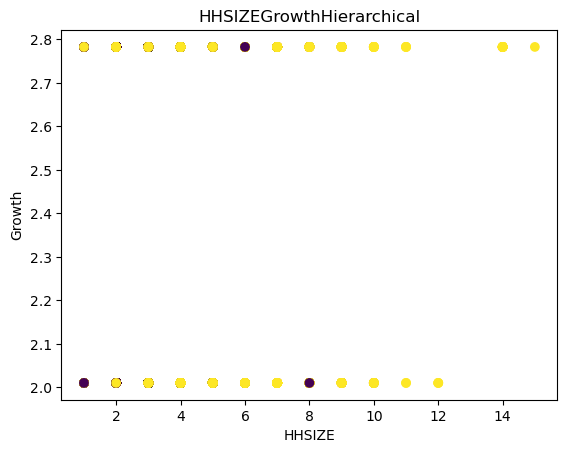

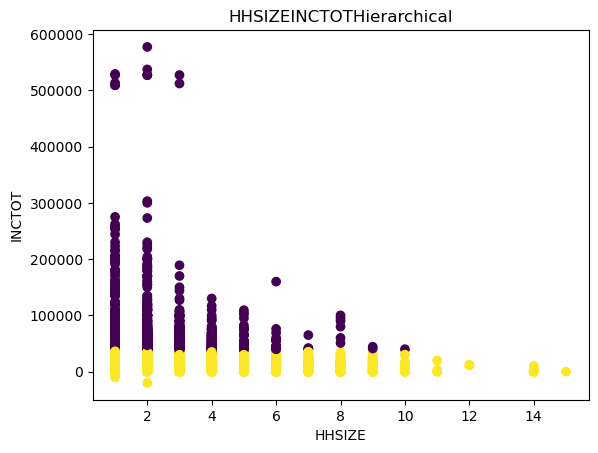

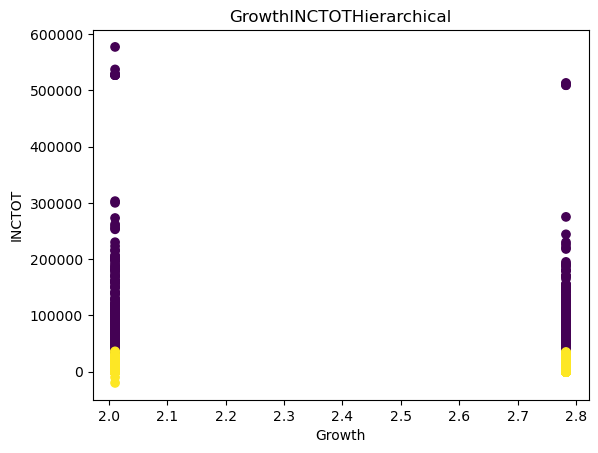

In [144]:
dfTemp = dfMerged[['HHSIZE', 'Growth','INCTOT']].copy()

clusterPlot(dfTemp)



## Regressions
1. OLS
2. LASSO -> OLS
3. LASSO -> LASSO

In [477]:
def changeColType(df,colList,dType):
    for col in colList:
        df[col] = df[col].astype(dType)

In [478]:
print(dfMerged.dtypes)
print(list(dfMerged))

RENT            float64
HHINCOME        float64
AGE             float64
INCTOT          float64
HHSIZE          float64
COLLEGE         float64
MULTIFAM        float64
ALONE           float64
Growth          float64
Unemployment    float64
10y2yspread     float64
dtype: object
['RENT', 'HHINCOME', 'AGE', 'INCTOT', 'HHSIZE', 'COLLEGE', 'MULTIFAM', 'ALONE', 'Growth', 'Unemployment', '10y2yspread']


In [479]:
df = dfMerged.copy()
df = df.drop('HHSIZE',axis=1)
print(df.head())


           RENT     HHINCOME       AGE      INCTOT  COLLEGE  MULTIFAM   ALONE  \
2006  149391.00   6906735.00   3861.00   6385500.0   148.50    148.50    0.00   
2006  570284.55  54802300.41  13632.30   9088200.0   454.41    454.41  454.41   
2006  351648.00  35563041.36  10549.44   9582408.0     0.00    439.56  439.56   
2006  519037.20  11850507.90  12622.50   7371540.0     0.00    504.90  504.90   
2006  672978.24  40147070.04  14980.68  28935759.6   576.18    576.18  576.18   

           Growth  Unemployment  10y2yspread  
2006   413.247246    684.337467    -3.512596  
2006  1264.536571   2094.072649   -10.748544  
2006  1223.211847   2025.638902   -10.397285  
2006  1405.040635   2326.747388   -11.942827  
2006  1603.399313   2655.229372   -13.628873  


In [480]:
#define x and y


varY = 'HHSIZE'

y = df[varY].astype('int')

X = df.copy()
X = X[['RENT', 'HHINCOME', 'AGE', 'INCTOT', 'COLLEGE', 'MULTIFAM',
       'Growth']]

# check data types
print(X.dtypes)
print(y.dtypes)

# check input shapes
print(X.shape)
print(y.shape)


#split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

KeyError: 'HHSIZE'

In [1]:
print(X.head())

NameError: name 'X' is not defined

Best alpha is  None


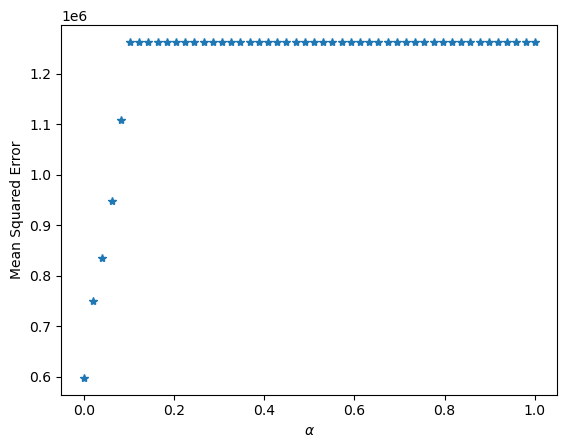

In [481]:
alphas = np.linspace(1e-6, 1, num=50)

coefList = list()
cvErrors = list()
MSE = 10
bestAlpha = None

# iterate over list of alphas
for a in alphas:
    
    # define pipeline object
    lassoReg = make_pipeline(StandardScaler(with_mean=False), Lasso(alpha= a * X_train.shape[0]))
    # run LASSO regression
    lassoReg.fit(X_train, y_train)
    
    # obtain predicted values of output
    y_pred = lassoReg.predict(X_test)
    
    # compute mean squared error
    cvErrors.append(mean_squared_error(y_test, y_pred))
    # store coefficients
    coefList.append(lassoReg['lasso'].coef_)
    
    # store value of alpha that minimizes the mean squared error
    if mean_squared_error(y_test, y_pred) < MSE: #np.mean((y_pred - y_test)**2)
        
        #update MSE and bestAlpha if new minimum is found
        MSE = mean_squared_error(y_test, y_pred)
        bestAlpha = a

        
#print best alpha
print('Best alpha is ',bestAlpha)

# plot
plt.plot(alphas, cvErrors, '*')
plt.xlabel(r'$\alpha$')
plt.ylabel('Mean Squared Error')

#show plot
plt.show()

Best alpha is  None


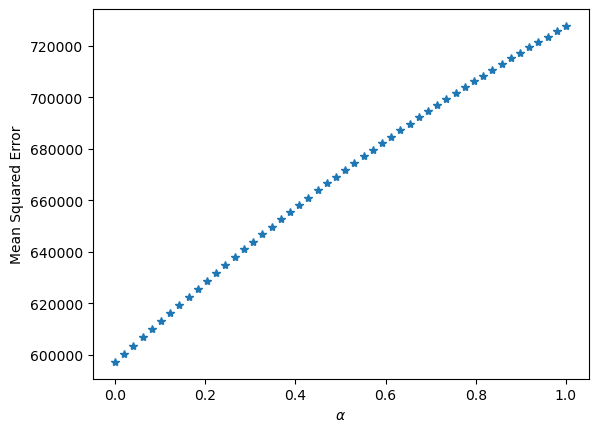

In [482]:
#make empty values for coefficients, cross validation errors, best alpha
#make arbitrary MSE value (high)
rcoefList = list()
rcvErrors = list()
rMSE = 10
rbestAlpha = None

# iterate over list of alphas
for a in alphas:
    
    # define pipeline object
    ridgeReg = make_pipeline(StandardScaler(with_mean=False), Ridge(alpha= a * X_train.shape[0]))
    # run Ridger regression
    ridgeReg.fit(X_train, y_train)
    
    # obtain predicted values of output
    y_pred = ridgeReg.predict(X_test)
    
    # compute mean squared error
    rcvErrors.append(mean_squared_error(y_test, y_pred))
    # store coefficients
    rcoefList.append(ridgeReg['ridge'].coef_)
    
    # store value of alpha that minimizes the mean squared error
    if mean_squared_error(y_test, y_pred) < rMSE: #np.mean((y_pred - y_test)**2)
        
        #update MSE and bestAlpha if new minimum is found
        rMSE = mean_squared_error(y_test, y_pred)
        rbestAlpha = a

        
#print best alpha
print('Best alpha is ',rbestAlpha)

# plot
plt.plot(alphas, rcvErrors, '*')
plt.xlabel(r'$\alpha$')
plt.ylabel('Mean Squared Error')

#show plot
plt.show()

In [483]:
#creating dataframe comparing coefficients of different methods
coef_comp=pd.DataFrame({'var':X.columns, 'val_lasso':lassoReg['lasso'].coef_, 'var_ridge':ridgeReg['ridge'].coef_})

#call
coef_comp

var  val_lasso   var_ridge
0      RENT        0.0  144.614468
1  HHINCOME        0.0   64.713186
2       AGE        0.0  154.558915
3    INCTOT        0.0  -81.603767
4   COLLEGE       -0.0  -97.740942
5  MULTIFAM        0.0  109.108073
6    Growth        0.0  194.895742

In [491]:
MLP = MLPClassifier(hidden_layer_sizes=(100,60),
                    activation='logistic', solver= 'lbfgs', 
                    max_iter =500,
                    verbose=True, learning_rate_init=0.01)
#Fit MLP on training data
MLP.fit(X_train,y_train) 

# Print accuracy of MLP model on training data
print(accuracy_score(y_train,MLP.predict(X_train)))
# Print accuracy of MLP model on testing data
print(accuracy_score(y_test, MLP.predict(X_test))) 

#Create a logit model fit on training data
# logitmodel = LogisticRegression(solver='liblinear').fit(X_train, y_train)

# # Print the accuracy of logit on training data
# print(accuracy_score(y_train,logitmodel.predict(X_train)))
# # Print the accuracy of logit on testing data
# print(accuracy_score(y_test, logitmodel.predict(X_test)) )


#print some descriptive stats for y_train and y_test
y_train.describe()
y_test.describe()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        84696     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.15898D+00    |proj g|=  1.02522D+00


 This problem is unconstrained.



At iterate    1    f=  7.14832D+00    |proj g|=  4.58518D-03

At iterate    2    f=  6.95877D+00    |proj g|=  2.21322D-03

At iterate    3    f=  6.88936D+00    |proj g|=  1.19133D-03

At iterate    4    f=  6.81657D+00    |proj g|=  2.01047D-03

At iterate    5    f=  6.79754D+00    |proj g|=  2.64400D-03

At iterate    6    f=  6.78880D+00    |proj g|=  6.15664D-01

At iterate    7    f=  6.78850D+00    |proj g|=  4.99912D-02

At iterate    8    f=  6.78803D+00    |proj g|=  2.11664D-01

At iterate    9    f=  6.78800D+00    |proj g|=  4.38934D-02

At iterate   10    f=  6.78793D+00    |proj g|=  1.44071D-02

At iterate   11    f=  6.78752D+00    |proj g|=  2.40422D-02

At iterate   12    f=  6.78610D+00    |proj g|=  1.49081D-03

At iterate   13    f=  6.78415D+00    |proj g|=  1.61367D-03

At iterate   14    f=  6.78057D+00    |proj g|=  1.02534D-03

At iterate   15    f=  6.77634D+00    |proj g|=  6.92235D-04

At iterate   16    f=  6.77102D+00    |proj g|=  8.60063D-04

At iter


At iterate  133    f=  5.93873D+00    |proj g|=  2.43286D-01

At iterate  134    f=  5.93873D+00    |proj g|=  1.37530D+00

At iterate  135    f=  5.93873D+00    |proj g|=  1.37915D+00

At iterate  136    f=  5.93873D+00    |proj g|=  2.15429D+00

At iterate  137    f=  5.93873D+00    |proj g|=  1.72121D+00

At iterate  138    f=  5.93873D+00    |proj g|=  1.70457D+00

At iterate  139    f=  5.93872D+00    |proj g|=  1.86072D+01

At iterate  140    f=  5.93872D+00    |proj g|=  3.72517D+00

At iterate  141    f=  5.93871D+00    |proj g|=  1.01682D+01

At iterate  142    f=  5.93871D+00    |proj g|=  9.32456D+00

At iterate  143    f=  5.93870D+00    |proj g|=  7.64772D+00

At iterate  144    f=  5.93869D+00    |proj g|=  5.97567D+00

At iterate  145    f=  5.93869D+00    |proj g|=  1.63832D+00

At iterate  146    f=  5.93869D+00    |proj g|=  2.21067D+00

At iterate  147    f=  5.93868D+00    |proj g|=  3.27410D+00

At iterate  148    f=  5.93868D+00    |proj g|=  1.84259D+00

At iter

count     788.000000
mean     1302.684010
std      1123.116763
min        78.000000
25%       498.000000
50%       962.500000
75%      1747.500000
max      8464.000000
Name: HHSIZE, dtype: float64

In [485]:
def OLSreg(x,y):
    return sm.OLS(y,x).fit()

def LASreg(X_train, X_test, y_train, y_test):
    
    lasso = Lasso()
    
    param_grid = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100]}

    # Perform Grid Search to find best hyperparameters
    lasso_grid = GridSearchCV(lasso, param_grid, cv=5)
    lasso_grid.fit(X_train, y_train)

    # Train Lasso Regression model using best hyperparameters
    lasso_model = Lasso(alpha=lasso_grid.best_params_['alpha'])
    lasso_model.fit(X_train, y_train)

    # Make predictions on test set
    y_pred = lasso_model.predict(X_test)
    
    # Evaluate model performance on test set
    mse = mean_squared_error(y_test, y_pred)
    print('Lasso Regression MSE:', mse)
    
    lasso_coef = lasso_model.coef_
    lasso_features = X_train.columns[lasso_coef != 0]

    # Print the non-zero coefficients and corresponding feature names
    print("Non-zero coefficients:")
    for feature, coef in zip(lasso_features, lasso_coef[lasso_coef != 0]):
        print(f"{feature}: {coef:.3f}")
    print(lasso_features)

In [486]:
LASreg(X_train, X_test, y_train, y_test)

Lasso Regression MSE: 597194.3234256798
Non-zero coefficients:
RENT: 0.001
HHINCOME: 0.000
AGE: 0.040
INCTOT: -0.000
COLLEGE: -1.128
MULTIFAM: 0.136
Growth: 0.769
Index(['RENT', 'HHINCOME', 'AGE', 'INCTOT', 'COLLEGE', 'MULTIFAM', 'Growth'], dtype='object')
